# Описание Проекта

   **Компания предоставила данные с характеристиками сотрудников компании.**
    
   Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

   Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

   У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

   Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
   Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

   **Теперь расскажем подробнее о задачах.**
    
    


Тренировочная выборка:
- `train_job_satisfaction_rate.csv`


Входные признаки тестовой выборки:
- `test_features.csv`


Целевой признак тестовой выборки:
- `test_target_job_satisfaction_rate.csv`

**Задача 1:** предсказание уровня удовлетворённости сотрудника


Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

**Задача 2:** предсказание увольнения сотрудника из компании


Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

Тренировочная выборка:
- `train_quit.csv`


Входные признаки тестовой выборки те же, что и в прошлой задаче:
- `test_features.csv`


Целевой признак тестовой выборки:
- `test_target_quit.csv`

**Цель исследования.**

Провести анализ данных при помощи которых предприятие разработает стратегию взаимодействия с клиентами.

# Шаг 1. Загрузка данных

# Подключение библиотек

Перед тем, как начнем работать, загрузим все библиотеки и модули

In [1]:
pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

     |████████████████████████████████| 533 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -U scikit-learn

     |████████████████████████████████| 10.9 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 78.5 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
import phik

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, r2_score, confusion_matrix,make_scorer
from sklearn.svm import SVC

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import warnings

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

**train_job_satisfaction_rate.csv**

Загрузим датасет с тренировочной выборкой:

In [5]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal = '.')
train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


**test_features.csv**

Загрузим датасет с входными признаками тестовой выборки:

In [6]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


**test_target_job_satisfaction_rate.csv**

Загрузим датасет с целевым признаком тестовой выборки:

In [7]:
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal = '.')
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Отлично! Данные были загружены, теперь перейдем к предобработке данных

**Вывод по загрузке данных:**

- Данные были загружены, также импортировали все нужные для работы и обучения моделей библиотеки и модули 

# Шаг 2. Предобработка данных

По поводу столбцов - если посмотреть на `head()` для каждого файла, то видно, что названия столбцов в каждом файле соответствуют требованиям (читаемость, можно snake стиль, информативность о признаке), поэтому переименовывать не будем

# Изменение типов данных

Перед тем, как проверить признаки на пропуски в данных, необходимо скорректировать все типы (если такая необходимость есть)

**train_job**

In [8]:
train_job.dtypes

id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object

In [9]:
train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [10]:
train_job['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [11]:
train_job['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

Итак, по поводу `train_job`, все типы данных изначально являются корректными, но для еще более высокой "корректности", можно подправить два признака (`last_year_promo` и `last_year_violations`), и сделать их бинарными (0, 1). А такие признаки, как `level`, `workload`, потом мы закодируем с помощью `OrdinalEncoder`.

In [12]:
train_job['last_year_promo'] = train_job['last_year_promo'].apply(lambda x: 1 if x == 'yes' else 0)
train_job['last_year_violations'] = train_job['last_year_violations'].apply(lambda x: 1 if x == 'yes' else 0)

train_job['last_year_promo'].unique()

array([0, 1])

In [13]:
train_job['last_year_violations'].unique()

array([0, 1])

In [14]:
train_job.dtypes

id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo            int64
last_year_violations       int64
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object

Отлично, признаки были поменяны на бинарные. Теперь посмотрим на следующий `df`

**test_features**

In [15]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [16]:
test_features.dtypes

id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
dtype: object

Здесь ситуация такая же, как и в тренировочном датасете, поэтому, так как мы там изменили признаки, то и тестовой выборке их тоже необходимо поменять, тк в дальнейшем будет использоваться `transform` для `LabelEncoder`.

In [17]:
test_features['last_year_promo'] = test_features['last_year_promo'].apply(lambda x: 1 if x == 'yes' else 0)
test_features['last_year_violations'] = test_features['last_year_violations'].apply(lambda x: 1 if x == 'yes' else 0)

test_features['last_year_promo'].unique()

array([0, 1])

In [18]:
test_features['last_year_violations'].unique()

array([0, 1])

In [19]:
test_features.dtypes

id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo           int64
last_year_violations      int64
supervisor_evaluation     int64
salary                    int64
dtype: object

Супер, данные в признаках и тип поменяли.

**test_target**

In [20]:
test_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [21]:
test_target.dtypes

id                         int64
job_satisfaction_rate    float64
dtype: object

Целевой признак трогать не будем, оставим типы как есть ( с ними все в порядке)

# Проверка данных на корректность и правильную запись

На этом этапе нужно проверить, чтобы данные не содержали ошибок (грамматические и т д)

Для удобства напишем функцию, которая выводит все уникальные данные из признаков

In [22]:
def unique_values_from_df(data):
    for i in data.columns:
        print('\n'*3, f"Уникальные значения в {i} - ", '\n')
        print(data[i].sort_values().unique())
    

In [23]:
unique_values_from_df(train_job)




 Уникальные значения в id -  

[100954 101057 101074 ... 999264 999348 999521]



 Уникальные значения в dept -  

['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]



 Уникальные значения в level -  

['junior' 'middle' 'sinior' nan]



 Уникальные значения в workload -  

['high' 'low' 'medium']



 Уникальные значения в employment_years -  

[ 1  2  3  4  5  6  7  8  9 10]



 Уникальные значения в last_year_promo -  

[0 1]



 Уникальные значения в last_year_violations -  

[0 1]



 Уникальные значения в supervisor_evaluation -  

[1 2 3 4 5]



 Уникальные значения в salary -  

[12000 13200 14400 15600 16800 18000 19200 20400 21600 22800 24000 25200
 26400 27600 28800 30000 31200 32400 33600 34800 36000 37200 38400 39600
 40800 42000 43200 44400 45600 46800 48000 49200 50400 51600 52800 54000
 55200 56400 57600 58800 60000 61200 62400 63600 64800 66000 67200 68400
 69600 70800 72000 73200 74400 75600 76800 78000 79200 80400 81600 84000
 85200 88800 91200 92400 94800 9

Уже видны пропуски, но они будут обработаны на следующем этапе

In [24]:
unique_values_from_df(test_features)




 Уникальные значения в id -  

[100298 100480 100503 ... 998762 998900 999029]



 Уникальные значения в dept -  

[' ' 'hr' 'marketing' 'purchasing' 'sales' 'technology' nan]



 Уникальные значения в level -  

['junior' 'middle' 'sinior' nan]



 Уникальные значения в workload -  

[' ' 'high' 'low' 'medium']



 Уникальные значения в employment_years -  

[ 1  2  3  4  5  6  7  8  9 10]



 Уникальные значения в last_year_promo -  

[0 1]



 Уникальные значения в last_year_violations -  

[0 1]



 Уникальные значения в supervisor_evaluation -  

[1 2 3 4 5]



 Уникальные значения в salary -  

[12000 13200 14400 15600 16800 18000 19200 20400 21600 22800 24000 25200
 26400 27600 28800 30000 31200 32400 33600 34800 36000 37200 38400 39600
 40800 42000 43200 44400 45600 46800 48000 49200 50400 51600 52800 54000
 55200 56400 57600 58800 60000 61200 62400 63600 64800 66000 67200 68400
 69600 70800 72000 73200 75600 76800 78000 79200 80400 81600 82800 84000
 86400 87600 88800 92400

Теперь появились пропуски с пустыми строками, их тоже разберем позже

In [25]:
unique_values_from_df(test_target)




 Уникальные значения в id -  

[100298 100480 100503 ... 998762 998900 999029]



 Уникальные значения в job_satisfaction_rate -  

[0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16
 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3
 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44
 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58
 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72
 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86
 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]


С целевым `df` вроде на первый взгляд все в порядке

# Проверка на наличие пропусков в данных и обработка дубликатов

Теперь будем проверять данные на пропуски (если пропуски менее 3% от общих данных, то мы бы их удалили), но в задании к проекту написано, что пропуски тут трогать не надо ( в проедобработке), а пофиксить их на этапе пайплайна, поэтому просто выведем общую информацию по пропускам в данных

**train_job**

In [26]:
train_job.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пропуски имеются, но их мало, обработаем в пайплайне

In [27]:
train_job.loc[train_job.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Дубликаты отсутствуют

**test_features**

In [28]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Пропуски тоже имеются (в пайплайн их все)

In [29]:
test_features[test_features.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


Дубликатов в `test_features` нет

**test_target**

In [30]:
test_target.isna().sum()

id                       0
job_satisfaction_rate    0
dtype: int64

Хорошо, пропусков нет

In [31]:
test_target.loc[test_target.duplicated()]

,id,job_satisfaction_rate


Дубликатов нет

**Вывод по предобработке данных:**
- Были изменены типы 2 признаков в тренирочной и тестовой выборках
- Данные были проверены на дубликаты (отсутствуют) и пропуски, но пропуски мы будем обрабатывать на этапе обучения модели


Данные были предобработны, изучены признаки, теперь перейдем к исследовательскому анализу


# Шаг 3. Исследовательский анализ данных

Исследуем все признаки и сделаем выводы о том, как их нужно подготовить.

Сперва исследуем признаки по-отдельности в каждом датасете (для тренировочного датасета посмотрим на корреляцию с целевым признаком), а в конце отберем признаки для кодирования в `cat`, `ord`, `num` признаки 

**train_job**

In [32]:
train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,0,0,1,24000,0.58
1,653870,hr,junior,high,2,0,0,5,38400,0.76
2,184592,sales,junior,low,1,0,0,2,12000,0.11
3,171431,technology,junior,low,4,0,0,2,18000,0.37
4,693419,hr,junior,medium,1,0,0,3,22800,0.20


In [33]:
train_job.dtypes

id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo            int64
last_year_violations       int64
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object

Пока добавим категориальные признаки и количественные в два списка

In [34]:
num_cols_tr_job = ['employment_years', 'last_year_promo', 'last_year_violations',
             'supervisor_evaluation', 'salary']

target_tr_job = 'job_satisfaction_rate'

cat_cols_tr_job = ['dept', 'level', 'workload'] 

Приступим к выводу графиков (начнем с `num` признаков)

## **train_jobs[num]**

Пройдемся отдельно по признакам и рассмотрим их, чтобы построить графики в зависимости от `job_satisfaction_rate`

In [35]:
train_job[num_cols_tr_job].head()

,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,2,0,0,1,24000
1,2,0,0,5,38400
2,1,0,0,2,12000
3,4,0,0,2,18000
4,1,0,0,3,22800


Итак, для признаков 
- `last_year_promo`,`last_year_violations` построим `bar`, так как они бинарные
- `salary` - `line`, чтобы посмотреть как зависит удовлетворенность от зарплаты
- `employment_years`, `supervisor_evaluation` - `bar`, чтобы увидеть по "корзинам" как распределяется довольство

**`last_year_promo`, `last_year_violations`** 

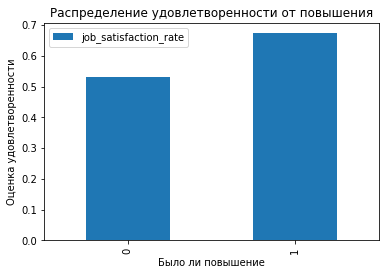

In [36]:
piv = train_job.pivot_table(index = 'last_year_promo', values = 'job_satisfaction_rate')

# aggfunc = 'mean' -  по умолчанию

piv.plot(kind = 'bar')
plt.xlabel('Было ли повышение')
plt.ylabel("Оценка удовлетворенности")
plt.title('Распределение удовлетворенности от повышения')
plt.show()

Очевидно, что те, у кого было повышение - более довольны работой

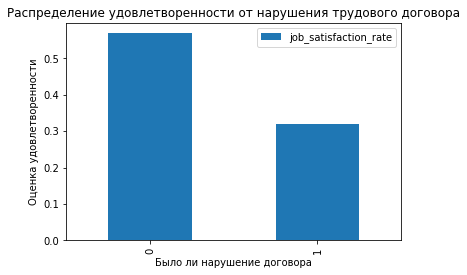

In [37]:
piv = train_job.pivot_table(index = 'last_year_violations', values = 'job_satisfaction_rate')

# aggfunc = 'mean' -  по умолчанию

piv.plot(kind = 'bar')
plt.xlabel('Было ли нарушение договора')
plt.ylabel("Оценка удовлетворенности")
plt.title('Распределение удовлетворенности от нарушения трудового договора')
plt.show()

У нарушителей могли быть штрафы или другие санкции, поэтому они и менее довольны работой

**`employment_years`, `supervisor_evaluation`** 

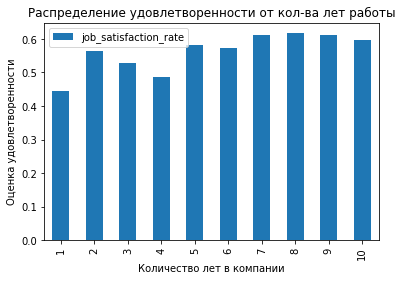

In [38]:
piv = train_job.pivot_table(index = 'employment_years', values = 'job_satisfaction_rate')

# aggfunc = 'mean' -  по умолчанию

piv.plot(kind = 'bar')
plt.ylabel('Оценка удовлетворенности')
plt.xlabel("Количество лет в компании")
plt.title('Распределение удовлетворенности от кол-ва лет работы')
plt.show()

По графику очень хорошо видно, что в основном меньше всего довольны те, кто проработал 1 и 4 года. Можно сказать, что в первый год идет адаптация работника, во 2 и 3 год привыкание окончательное, может даже на 4 год выгорание (поэтому опять недовольство). Ну а чем дольше человек работает, тем выше его удовлетворенность от работы, может, что он окончательно привык, и поэтому недовольства нет

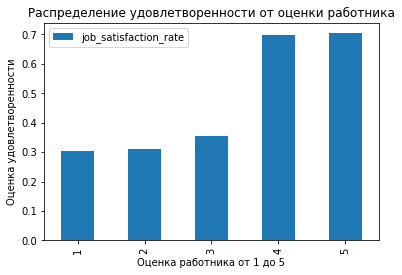

In [39]:
piv = train_job.pivot_table(index = 'supervisor_evaluation', values = 'job_satisfaction_rate')

# aggfunc = 'mean' -  по умолчанию

piv.plot(kind = 'bar')
plt.ylabel('Оценка удовлетворенности')
plt.xlabel("Оценка работника от 1 до 5")
plt.title('Распределение удовлетворенности от оценки работника')
plt.show()

Самая низкая удовлетворенность у тех, у кого низкие оценки от работодателя (1 - 3), видимо, что они и работают плохо, тк им не нравится своя работа

**`salary`**

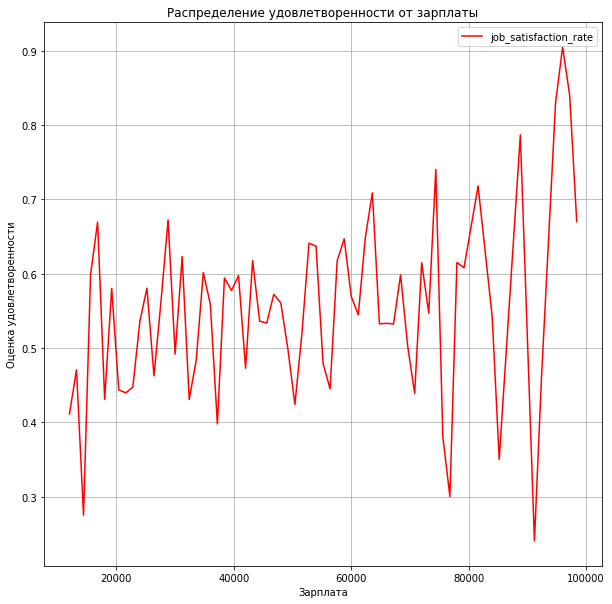

In [40]:
piv = train_job.pivot_table(index = 'salary', values = 'job_satisfaction_rate')

# aggfunc = 'mean' -  по умолчанию

piv.plot(figsize= (10,10), grid = True, color = 'red',)
plt.ylabel('Оценка удовлетворенности')
plt.xlabel("Зарплата")
plt.title('Распределение удовлетворенности от зарплаты')
plt.show()

Чем выше зарплата - тем выше удовлетворенность, хотя также есть и выбросы на высоких значениях ЗП, но я считаю, что это норма - недовольные могут быть везде

По данным графикам можно сказать, что у нас отсутствует прямая линейная связь между `num` признаками и целевым, может в дальнейшем придется добавить новый признак, чтобы была лучше зависимость

- А пока для наглядности выведем матрицу корреляции, и затем оставим в ней только те значения, которые больше порога 0.6 (возьмем чуть больше среднего)

Text(0.5, 1.0, 'Correlation Matrix')

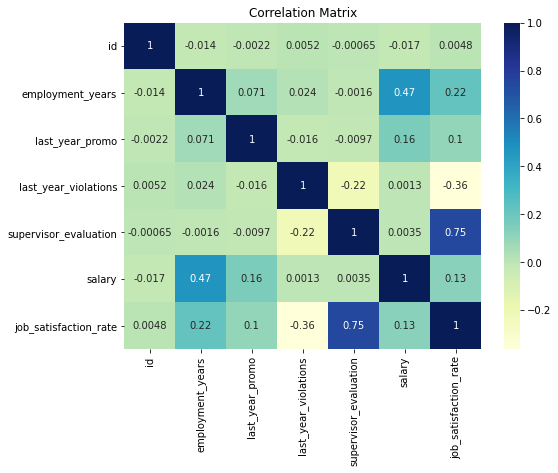

In [41]:
correlation_matrix = train_job.corr(method = 'spearman')

# Настраиваем heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Matrix')


По матрице корреляции видно, что есть связь (и самая сильная) в признаке `supervisor_evaluation` - это оценка качества работы сотрудника, которую дал руководитель. И если посмотреть по графику, то чем выше оценку ставит работадатель подчиненному, тем выше его удовлетворенность работой. Может быть, что таким работникам выплачиваются доп премии?? Об этом узнаем позже

In [42]:
# Оставляем только значения, у которых корреляция больше заданного параметра
threshold = 0.6
high_corr = correlation_matrix[(correlation_matrix > threshold) & (correlation_matrix < 1.0)]
print(high_corr)

                       id  employment_years  last_year_promo  \
id                    NaN               NaN              NaN   
employment_years      NaN               NaN              NaN   
last_year_promo       NaN               NaN              NaN   
last_year_violations  NaN               NaN              NaN   
supervisor_evaluation NaN               NaN              NaN   
salary                NaN               NaN              NaN   
job_satisfaction_rate NaN               NaN              NaN   

                       last_year_violations  supervisor_evaluation  salary  \
id                                      NaN                    NaN     NaN   
employment_years                        NaN                    NaN     NaN   
last_year_promo                         NaN                    NaN     NaN   
last_year_violations                    NaN                    NaN     NaN   
supervisor_evaluation                   NaN                    NaN     NaN   
salary             

Эх, у нас всего одно значения с корреляцией выше 0.6, и это оценка от руководства

По данным графикам, которые были построены для количественных признаков и целевого видно, что:
- Чем выше оценка у работника от руководителей, тем выше его удовлетворенность
- Почти нет зависимости между признаками

Построим `plot` для тестовой выборки и сравним их с `train`

In [43]:
test_conc = test_features.merge(test_target, how = 'inner', on = 'id')
test_conc.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,0,0,5,28800,0.79
1,686555,hr,junior,medium,1,0,0,4,30000,0.72
2,467458,sales,middle,low,5,0,0,4,19200,0.64
3,418655,sales,middle,low,6,0,0,4,19200,0.60
4,789145,hr,middle,medium,5,0,0,5,40800,0.75


Text(0.5, 1.0, 'Correlation Matrix')

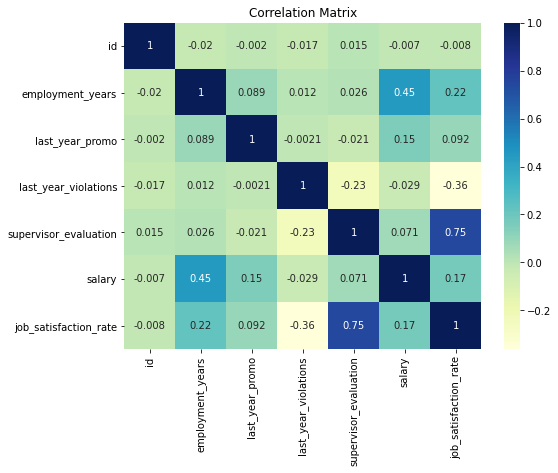

In [44]:
correlation_matrix = test_conc.corr(method = 'spearman')

# Настраиваем heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Matrix')


По сути, тут данные не сильно отличаются от `train`, разница буквально в сотых долях, так что за модель можно быть спокойным (что она корректно отработает на тестовой выборке и в последствии на реальных, обучившись на имеющихся тренировочных данных)

## **train_jobs[cat]**

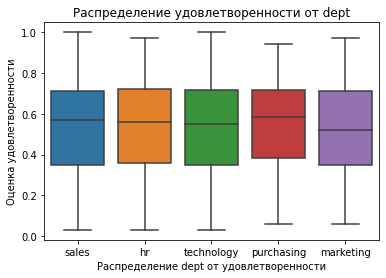

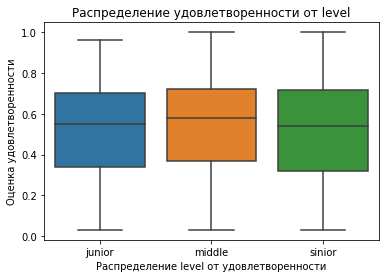

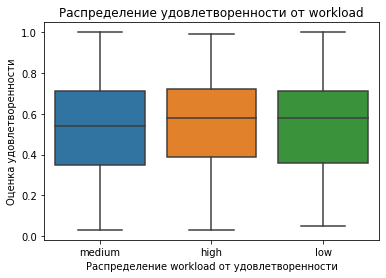

In [45]:
for i in cat_cols_tr_job:
    
    #train_job.plot(kind = 'hist', x =  i , y = target_tr_job, figsize=(5, 5))
    sns.boxplot(x=i , y=target_tr_job, data=train_job)
    plt.ylabel('Оценка удовлетворенности')
    plt.xlabel(f"Распределение {i} от удовлетворенности")
    plt.title(f'Распределение удовлетворенности от {i}')
    plt.show()

В принципе, разницы особой нет, кто-то немного больше доволен, кто-то немного меньше, но везде около 50% значений удовлетворенности в промежутке (от 0.37 до 0.7)
- Посмотрим потом на результаты, которые получим с модели

Построим `boxplot` для тестовой выборки и сравним их с `train`

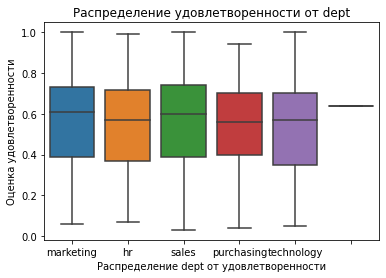

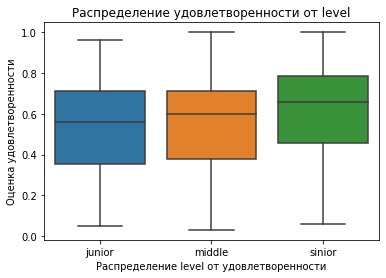

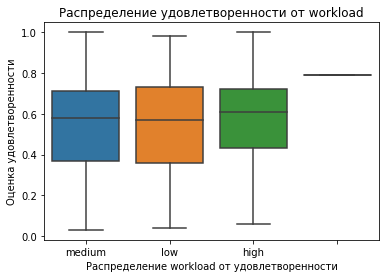

In [46]:
for i in cat_cols_tr_job:
    
    #train_job.plot(kind = 'hist', x =  i , y = target_tr_job, figsize=(5, 5))
    sns.boxplot(x=i , y='job_satisfaction_rate', data=test_conc)
    plt.ylabel('Оценка удовлетворенности')
    plt.xlabel(f"Распределение {i} от удовлетворенности")
    plt.title(f'Распределение удовлетворенности от {i}')
    plt.show()

Итак, есть небольшая разница между построенными `boxplot` для `train` и `test`:
- В `test` у нас есть пустые графики справа - это те самые пропуски, которые будут обработаны на этапе составления `pipeline`, поэтому на них не обращаем внимания
- В `test` немножко другое распределение, например верхняя граница поднимается до значения `0.8` у некоторых признаков, а на `train` выборке было примерно `0.7`. Я считаю, что это не сильно критично

## ord - признаки

Теперь отдельно рассмотрим `ord` признаки, а в конце все данные поделим по спискам `num`, `ord`, `cat`

In [47]:
train_job.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,0,0,1,24000,0.58
1,653870,hr,junior,high,2,0,0,5,38400,0.76
2,184592,sales,junior,low,1,0,0,2,12000,0.11
3,171431,technology,junior,low,4,0,0,2,18000,0.37
4,693419,hr,junior,medium,1,0,0,3,22800,0.20


In [48]:
ord_train = ['level', 'workload']

Для `ord` списка у нас получилось выбрать всего 2 признака из датасета, посмотрим на их уникальные значения

In [49]:
train_job['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [50]:
train_job['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

Построим графики для этих признаков

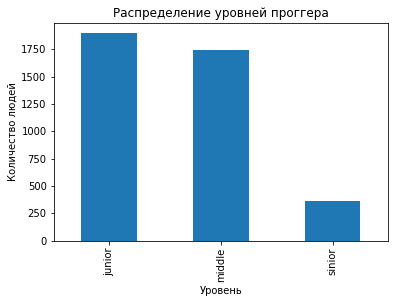

In [51]:
train_job['level'].value_counts().plot(
    kind = 'bar', 
    title = 'Распределение уровней проггера',
    xlabel = 'Уровень',
    ylabel = 'Количество людей'
    )
plt.show()

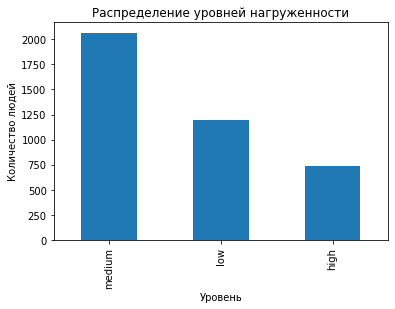

In [52]:
train_job['workload'].value_counts().plot(
    kind = 'bar', 
    title = 'Распределение уровней нагруженности',
    xlabel = 'Уровень',
    ylabel = 'Количество людей'
    )
plt.show()

В компании больше всего junior специалистов, и в основном у людей средняя загруженность на работе

## Деление на num, ord, cat

In [53]:
#списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Отлично, выделили признаки, чтобы использовать потом на них `..Encoder`

**Вывод по исследовательскому анализу:**
- Данные были поделены на количественные и категориальные признаки
- Были исследованы зависимости сперва количественных, а затем и категориальных признаков от целевого (и на тестовой выборке проверили в дополнении)
- Были найдены некоторые зависимости между признаками

# Шаг 4. Подготовка данных

На этом этапе необходимо подготовить данные для обучения в пайплайн

In [54]:
#списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

Создание `pipeline`ов

In [55]:
X_train = train_job.drop(['id'], axis=1)
#y_train = train_job['job_satisfaction_rate']

Проверим тренировочную выборку на наличие неявных дубликатов, и, если они есть, то удалим

In [56]:
X_train.duplicated().sum()

245

Удалим явные дубликаты из тренировочной выборки

In [57]:
X_train = X_train.drop_duplicates()

X_train.shape

(3755, 9)

In [58]:
X_train.duplicated().sum()

0

In [59]:
y_train = X_train['job_satisfaction_rate']
X_train = X_train.drop(['job_satisfaction_rate'], axis = 1)

In [60]:
test_features = test_features.sort_values(by = 'id')

In [61]:
test_target = test_target.sort_values(by = 'id')

In [62]:
X_test = test_features
y_test = test_target['job_satisfaction_rate']

In [63]:
X_test.head(), y_test.head()

(          id        dept   level workload  employment_years  last_year_promo  \
 1172  100298          hr  junior      low                 2                0   
 852   100480   marketing  junior      low                 4                0   
 848   100503  purchasing  middle     high                 5                0   
 524   100610       sales  middle   medium                 5                0   
 476   100692       sales  middle     high                 6                0   
 
       last_year_violations  supervisor_evaluation  salary  
 1172                     0                      4   19200  
 852                      0                      4   16800  
 848                      0                      4   55200  
 524                      0                      4   43200  
 476                      0                      4   48000  ,
 1734    0.80
 1467    0.84
 190     0.79
 60      0.75
 231     0.69
 Name: job_satisfaction_rate, dtype: float64)

In [64]:
RANDOM_STATE = 42

#X_train = train_job.drop(['id', 'job_satisfaction_rate'], axis=1)
#y_train = train_job['job_satisfaction_rate']

# подготовка признаков из ohe_columns
ohe_pipe = Pipeline(
[
    (
        'simpleImputer_ohe_nan', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    ),
    (
        'simpleImputer_ohe_blank', SimpleImputer(missing_values = ' ', strategy = 'most_frequent')
    ),
    (
        'ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)
    )
]
)


# подготовка признаков из ord_columns
ord_pipe = Pipeline(
[
    (
        'simpleImputer_before_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    ),
    (
        'ord', OrdinalEncoder(handle_unknown = 'use_encoded_value',
                             categories = [
                                 ['junior', 'middle', 'sinior'],
                                 ['low', 'medium', 'high']
                             ], unknown_value = np.nan)
    ),
    (
        'simpleImputer_after_ord', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    )
]
)

'''
# подготовка признаков из num_columns
num_pipe = Pipeline(
[
    (
    
    ),
    (
    
    ),
    (
    
    ),
    
]
)
'''

data_preprocessor = ColumnTransformer(
[

    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
],
      remainder = 'passthrough'
)


# финальный пайп
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)


# словарь гиперпараметров для моделей (дерево и регрессия)
param_grid = [
 
    {
     'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 50),
     'models__max_features': range(2, 30),
     'models__min_samples_split': [2, 5, 10, 12, 15, 18, 20, 22, 34],  
     'models__min_samples_leaf': [1, 2, 4, 8, 16, 32, 35, 40], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
 
    {
     'models': [LinearRegression()],
     'models__fit_intercept': [True, False], 
     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
 
]

Отлично, получилось сделать пайплайн, который и обрабатывает пропуска, и заполняет их. Перейдем к обучению модели

# Шаг 5. Обучение моделей

На этом этапе необходимо написать свою функцию-метрику `SMAPE`, у которой критерий успеха = (Критерий успеха: SMAPE ≤ 15 на тестовой выборке.)

После этого обучим модели на тренировочной выборке и проверим результаты метрики качества.

In [65]:
# метрика SMAPE
def smape(y_test, pred):
    #metric = np.mean((2 * np.abs(pred - y_test) / (np.abs(y_test) + np.abs(pred))))*100 
    #metric = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    metric = 100*(np.mean(2 * np.abs(pred - y_test) / (np.abs(y_test) + np.abs(pred))))
    return metric


scorer_smape = make_scorer(smape, greater_is_better = False)

In [66]:
X_train.shape, y_train.shape

((3755, 8), (3755,))

In [67]:
warnings.filterwarnings('ignore')

f = (-1)/10**5

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring= scorer_smape,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)
 
 
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика SMAPE лучшей модели на тренировочной выборке:', randomized_search.best_score_ * (-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe_nan',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_blank',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                      

Итак, полученная метрика `SMAPE` (лучшая) равна 15.7, что почти 16 (при критерии успеха <= 15), поэтому, можно считать, что модель справилась с задачей удачно.

- Лучшая модель DecisionTreeRegressor(max_depth=16, max_features=16, min_samples_split=20), она справилась лучше, так как когда были построены графики, то сразу стало понятно, что обычная линейная регрессия не справится с такой задачей, потому что в данных не было сильной линейной зависимости

In [68]:
X_test.head(), X_test.shape

(          id        dept   level workload  employment_years  last_year_promo  \
 1172  100298          hr  junior      low                 2                0   
 852   100480   marketing  junior      low                 4                0   
 848   100503  purchasing  middle     high                 5                0   
 524   100610       sales  middle   medium                 5                0   
 476   100692       sales  middle     high                 6                0   
 
       last_year_violations  supervisor_evaluation  salary  
 1172                     0                      4   19200  
 852                      0                      4   16800  
 848                      0                      4   55200  
 524                      0                      4   43200  
 476                      0                      4   48000  ,
 (2000, 9))

In [69]:
y_test.head(), y_test.shape

(1734    0.80
 1467    0.84
 190     0.79
 60      0.75
 231     0.69
 Name: job_satisfaction_rate, dtype: float64,
 (2000,))

In [70]:
y_pred= randomized_search.predict(X_test)

smape(y_test, y_pred)

13.785100155894659

Ого, долго просидел с этой тестовой выборкой, пока понял что вообще надо делать, но все шаги выше добавил.

На тестовой получили почти 14, что очень хороший результат, может эту модель даже отправить на реальные данные?)

# Задача 2

В этой задаче требуется предсказать уход (увольнение сотрудника) и т.к. данные совпадают (кроме целевого признака), поэтому я `merge` новый целевой признак `quit` для уже предобработанных таблиц `train` и `тест` 

- Тренировочная выборка:
- `train_quit.csv`


- Входные признаки тестовой выборки те же, что и в прошлой задаче:
- `test_features.csv`


- Целевой признак тестовой выборки:
- `test_target_quit.csv`

In [71]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit_2= pd.read_csv('/datasets/train_quit.csv')
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Появился новый признак в тренировочной выборке - `quit`, который показывает уйдет сотрудник или нет

In [72]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,0,0,4,19200
852,100480,marketing,junior,low,4,0,0,4,16800
848,100503,purchasing,middle,high,5,0,0,4,55200
524,100610,sales,middle,medium,5,0,0,4,43200
476,100692,sales,middle,high,6,0,0,4,48000


In [73]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Датасет с целевым признаком `quit` для тестовой выборки

Теперь, необходимо в `train_quit`, `test_features` добавить новый признак `job_satisfaction_rate`, но перед этим поменять значения на бинарные в признаках

In [74]:
train_quit['last_year_promo'] = train_quit['last_year_promo'].apply(lambda x: 1 if x == 'yes' else 0)
train_quit['last_year_violations'] = train_quit['last_year_violations'].apply(lambda x: 1 if x == 'yes' else 0)

train_quit['last_year_promo'].unique()

array([0, 1])

In [75]:
test_features['job_satisfaction_rate'] = randomized_search.predict(test_features)

test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1172,100298,hr,junior,low,2,0,0,4,19200,0.832222
852,100480,marketing,junior,low,4,0,0,4,16800,0.841667
848,100503,purchasing,middle,high,5,0,0,4,55200,0.769333
524,100610,sales,middle,medium,5,0,0,4,43200,0.815000
476,100692,sales,middle,high,6,0,0,4,48000,0.702500


In [76]:
train_quit['job_satisfaction_rate'] = randomized_search.predict(train_quit.drop(columns = ['quit'], axis = 1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,0,0,4,54000,no,0.647778
1,814010,sales,junior,medium,2,0,0,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,0,0,1,37200,no,0.340000
3,257132,sales,junior,medium,2,0,1,3,24000,yes,0.356875
4,910140,marketing,junior,medium,2,0,0,5,25200,no,0.690000


# Шаг 2. Предобработка данных

**train_quit**

## **Проверка типов данных**

In [77]:
train_quit.dtypes

id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo            int64
last_year_violations       int64
supervisor_evaluation      int64
salary                     int64
quit                      object
job_satisfaction_rate    float64
dtype: object

In [78]:
test_target_quit.dtypes

id       int64
quit    object
dtype: object

Тут все в порядке, теперь проверим данные на дубликаты и пропуски (но пропуски нужно обработать будет также в пайплайне)

## Пропуски

In [79]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
job_satisfaction_rate    0
dtype: int64

In [80]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

Пропусков нет, все в порядке, но стоит еще проверить все уникальные значения датасетов

In [81]:
unique_values_from_df(train_quit)




 Уникальные значения в id -  

[100222 100459 100469 ... 999158 999835 999915]



 Уникальные значения в dept -  

['hr' 'marketing' 'purchasing' 'sales' 'technology']



 Уникальные значения в level -  

['junior' 'middle' 'sinior']



 Уникальные значения в workload -  

['high' 'low' 'medium']



 Уникальные значения в employment_years -  

[ 1  2  3  4  5  6  7  8  9 10]



 Уникальные значения в last_year_promo -  

[0 1]



 Уникальные значения в last_year_violations -  

[0 1]



 Уникальные значения в supervisor_evaluation -  

[1 2 3 4 5]



 Уникальные значения в salary -  

[12000 13200 14400 15600 16800 18000 19200 20400 21600 22800 24000 25200
 26400 27600 28800 30000 31200 32400 33600 34800 36000 37200 38400 39600
 40800 42000 43200 44400 45600 46800 48000 49200 50400 51600 52800 54000
 55200 56400 57600 58800 60000 61200 62400 63600 64800 66000 67200 68400
 69600 70800 72000 73200 74400 75600 76800 78000 79200 80400 81600 82800
 84000 85200 86400 87600 88800 91200 924

In [82]:
unique_values_from_df(test_target_quit)




 Уникальные значения в id -  

[100298 100480 100503 ... 998762 998900 999029]



 Уникальные значения в quit -  

['no' 'yes']


Все хорошо, идём дальше

## Дубликаты

In [83]:
train_quit.loc[train_quit.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate


In [84]:
test_target_quit.loc[test_target_quit.duplicated()]

,id,quit


Дубликатов нет

**Итоги предобработки данных для второй задачи:**
- Дубликатов нет 
- Пропусков нет

# Шаг 3. Исследовательский анализ данных

## Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

На этом этапе решим 3 задачи:
- Построим график с количеством уволившихся сотрудников
- Построим `scatterplot`, который показывает связь между удовлетворенностью, зарплатой и тем, уволился ли сотрудник
- Построим график с распределением загруженности уволившихся сотрудников ( и тех, кто не уволился)
- Посмотрим на корреляцию между всеми признаками


На уход больше всего влияют такие признаки, как удовлетворенность, зарплата, загруженность, так как это самые основные факторы (остальыне можно сказать побочные)

**Количество уволившихся сотрудников:**

In [85]:
train_quit['job_satisfaction_rate'].head()

0    0.647778
1    0.853529
2    0.340000
3    0.356875
4    0.690000
Name: job_satisfaction_rate, dtype: float64

In [86]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,0,0,4,54000,no,0.647778
1,814010,sales,junior,medium,2,0,0,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,0,0,1,37200,no,0.340000
3,257132,sales,junior,medium,2,0,1,3,24000,yes,0.356875
4,910140,marketing,junior,medium,2,0,0,5,25200,no,0.690000


In [87]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1172,100298,hr,junior,low,2,0,0,4,19200,0.832222
852,100480,marketing,junior,low,4,0,0,4,16800,0.841667
848,100503,purchasing,middle,high,5,0,0,4,55200,0.769333
524,100610,sales,middle,medium,5,0,0,4,43200,0.815000
476,100692,sales,middle,high,6,0,0,4,48000,0.702500


Отсортируем по `id`, чтобы соединить признак удовлетворения и уход с компании

In [88]:
test_target_quit = test_target_quit.sort_values(by = 'id')

In [89]:
test_target_quit.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [90]:
test_features = test_features.reset_index(drop = True)

test_features

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,0,0,4,19200,0.832222
1,100480,marketing,junior,low,4,0,0,4,16800,0.841667
2,100503,purchasing,middle,high,5,0,0,4,55200,0.769333
3,100610,sales,middle,medium,5,0,0,4,43200,0.815000
4,100692,sales,middle,high,6,0,0,4,48000,0.702500
...,...,...,...,...,...,...,...,...,...,...
1995,997290,sales,sinior,medium,7,0,0,4,58800,0.841667
1996,998548,marketing,junior,medium,2,0,0,4,32400,0.793333
1997,998762,technology,junior,low,3,0,0,3,22800,0.480000
1998,998900,marketing,middle,medium,7,0,0,3,45600,0.475455


In [91]:
test_target_quit.head()

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


In [92]:
test_target_quit = test_target_quit.reset_index(drop=True)

test_target_quit['job_satisfaction_rate'] = test_features['job_satisfaction_rate']

In [93]:
test_target_quit.head()

,id,quit,job_satisfaction_rate
0,100298,no,0.832222
1,100480,no,0.841667
2,100503,no,0.769333
3,100610,no,0.815000
4,100692,no,0.702500


Итак, получилось соединить два тестовых датафрейма (заранее отсортировав по id)

In [94]:
train_quit.shape

(4000, 11)

**Графики**

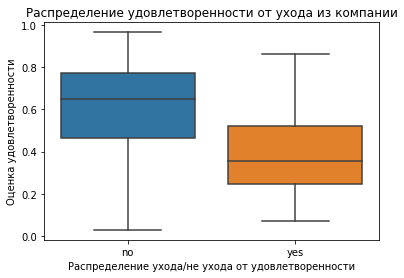

In [95]:

sns.boxplot(x='quit' , y='job_satisfaction_rate', data=train_quit)
plt.ylabel('Оценка удовлетворенности')
plt.xlabel(f"Распределение ухода/не ухода от удовлетворенности")
plt.title(f'Распределение удовлетворенности от ухода из компании')
plt.show()

На этом графике можно заметить, что больше всего уволенных на уровне удовлетворенности около 0.5 - 0.8, а меньше всего после 0.3 - 0.6. Среднее значение у неушедших около 0.65, у уволенных на 0.35

**Построим scatterplot, который показывает связь между удовлетворенностью, зарплатой и тем, уволился ли сотрудник**

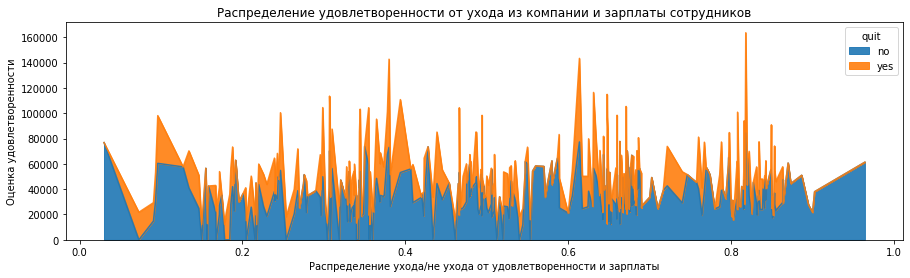

In [96]:
piv = train_quit.pivot_table(index = 'job_satisfaction_rate', values = 'salary', columns = 'quit')

#piv.plot(kind = 'hist',figsize = (15,15), alpha = 0.5)
piv.plot(kind = 'area', figsize = (15,4), alpha = 0.9)
plt.ylabel('Оценка удовлетворенности')
plt.xlabel(f"Распределение ухода/не ухода от удовлетворенности и зарплаты")
plt.title(f'Распределение удовлетворенности от ухода из компании и зарплаты сотрудников')
plt.show()

По графику видно как распределяется зарплата и уход, в зависимости от удовлетворенности сотрудником работой в компании. Можно сказать, что самые частые "уходы" у людей с высокой зарплатой и удовлетворенностью от 0.1 до 0.6

In [97]:
piv = train_quit.pivot_table( index = 'salary', columns = 'quit', aggfunc = 'size')

#piv.plot(kind = 'hist',figsize = (15,15), alpha = 0.5)
#piv.plot(kind = 'bar', figsize = (15,4), alpha = 0.9)
#piv.plot.bar(x = 'salary', y = 'quit', figsize = (15,4), alpha = 0.9)
#plt.ylabel('Оценка удовлетворенности')
#plt.xlabel(f"Распределение ухода/не ухода от удовлетворенности и зарплаты")
#plt.title(f'Распределение удовлетворенности от ухода из компании и зарплаты сотрудников')
#plt.show()
piv

quit,no,yes
salary,,
12000,11.0,97.0
13200,6.0,46.0
14400,6.0,51.0
15600,40.0,67.0
16800,22.0,23.0
...,...,...
88800,2.0,NaN
91200,1.0,NaN
92400,1.0,NaN


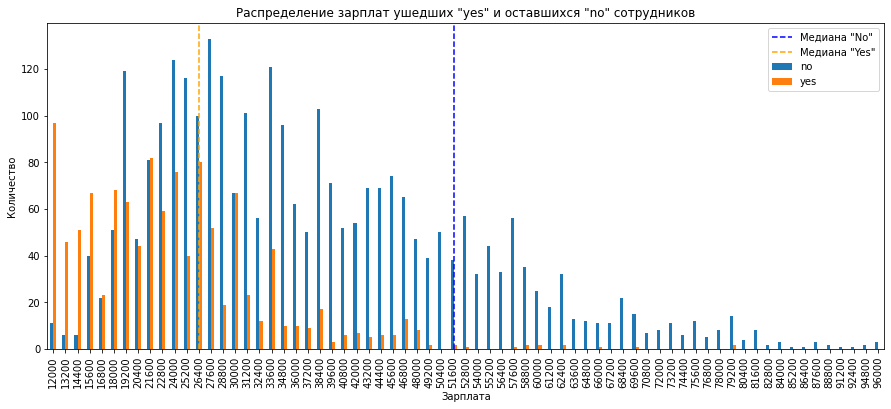

In [98]:

# Создание сводной таблицы
pivot = train_quit.pivot_table(index='salary', columns='quit', aggfunc='size')

# Построение столбчатой диаграммы
pivot.plot(kind='bar', figsize=(15, 6))

# Добавление медиан
plt.axvline(x=pivot['no'].median(), color='blue', linestyle='--', label='Медиана "No"')
plt.axvline(x=pivot['yes'].median(), color='orange', linestyle='--', label='Медиана "Yes"')

# Добавление легенды
plt.legend()

# Добавление названий осей и заголовка
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.title('Распределение зарплат ушедших "yes" и оставшихся "no" сотрудников')

# Отображение графика
plt.show()

Этот график уже более информативен, на нем видно, что:
- голубые точки показывают уволившихся, и чем меньше зарплата и удовлетворенность, соответственно тем больше сотрудников уволилось
- Те, кто доволен работой - очень много, и количество ушедших стремится к нулю

**Построим график с распределением загруженности уволившихся сотрудников ( и тех, кто не уволился)**

In [99]:
'''
# создание группированных данных
grouped = train_quit.groupby(['quit', 'workload']).size().unstack()

# построение столбчатой диаграммы
grouped.plot(kind='bar', stacked=False, color=['skyblue', 'lightgreen', 'coral'])

# добавление легенды и меток
plt.legend(title='Загруженность')
plt.xlabel('Увольнения')
plt.ylabel('Кол-во увольнений')
plt.title('Распределение нагруженности работников от увольнений')

# показать график
plt.show()
'''

"\n# создание группированных данных\ngrouped = train_quit.groupby(['quit', 'workload']).size().unstack()\n\n# построение столбчатой диаграммы\ngrouped.plot(kind='bar', stacked=False, color=['skyblue', 'lightgreen', 'coral'])\n\n# добавление легенды и меток\nplt.legend(title='Загруженность')\nplt.xlabel('Увольнения')\nplt.ylabel('Кол-во увольнений')\nplt.title('Распределение нагруженности работников от увольнений')\n\n# показать график\nplt.show()\n"

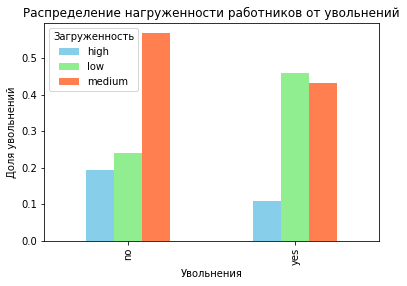

In [100]:

# создание группированных данных
grouped = train_quit.groupby(['quit', 'workload']).size().unstack()

# преобразование в относительные величины
grouped_rel = grouped.div(grouped.sum(axis=1), axis=0)

# построение столбчатой диаграммы
grouped_rel.plot(kind='bar', stacked=False, color=['skyblue', 'lightgreen', 'coral'])

# добавление легенды и меток
plt.legend(title='Загруженность')
plt.xlabel('Увольнения')
plt.ylabel('Доля увольнений')
plt.title('Распределение нагруженности работников от увольнений')

# показать график
plt.show()

Для построения графика по относительным величинам нужно поделить значения каждой группы на сумму значений всех групп. Поэтому тут можно использовать метод `div` для деления каждой строки на сумму значений в строке

Наблюдается очень интересная картина, больше всего увольнений и не увольнений приходится именно на `medium`, видимо самый "костяк" компании, и этих людей больше всего, поэтому и такое распределение, а тех, у кого `low`- скорее всего это стажеры и практиканты, поэтому и мало работают. Меньше всего уволенных в `high` загруженности, вероятно это очень важные для компании сотрудники 

**Посмотрим на корреляцию между всеми признаками**

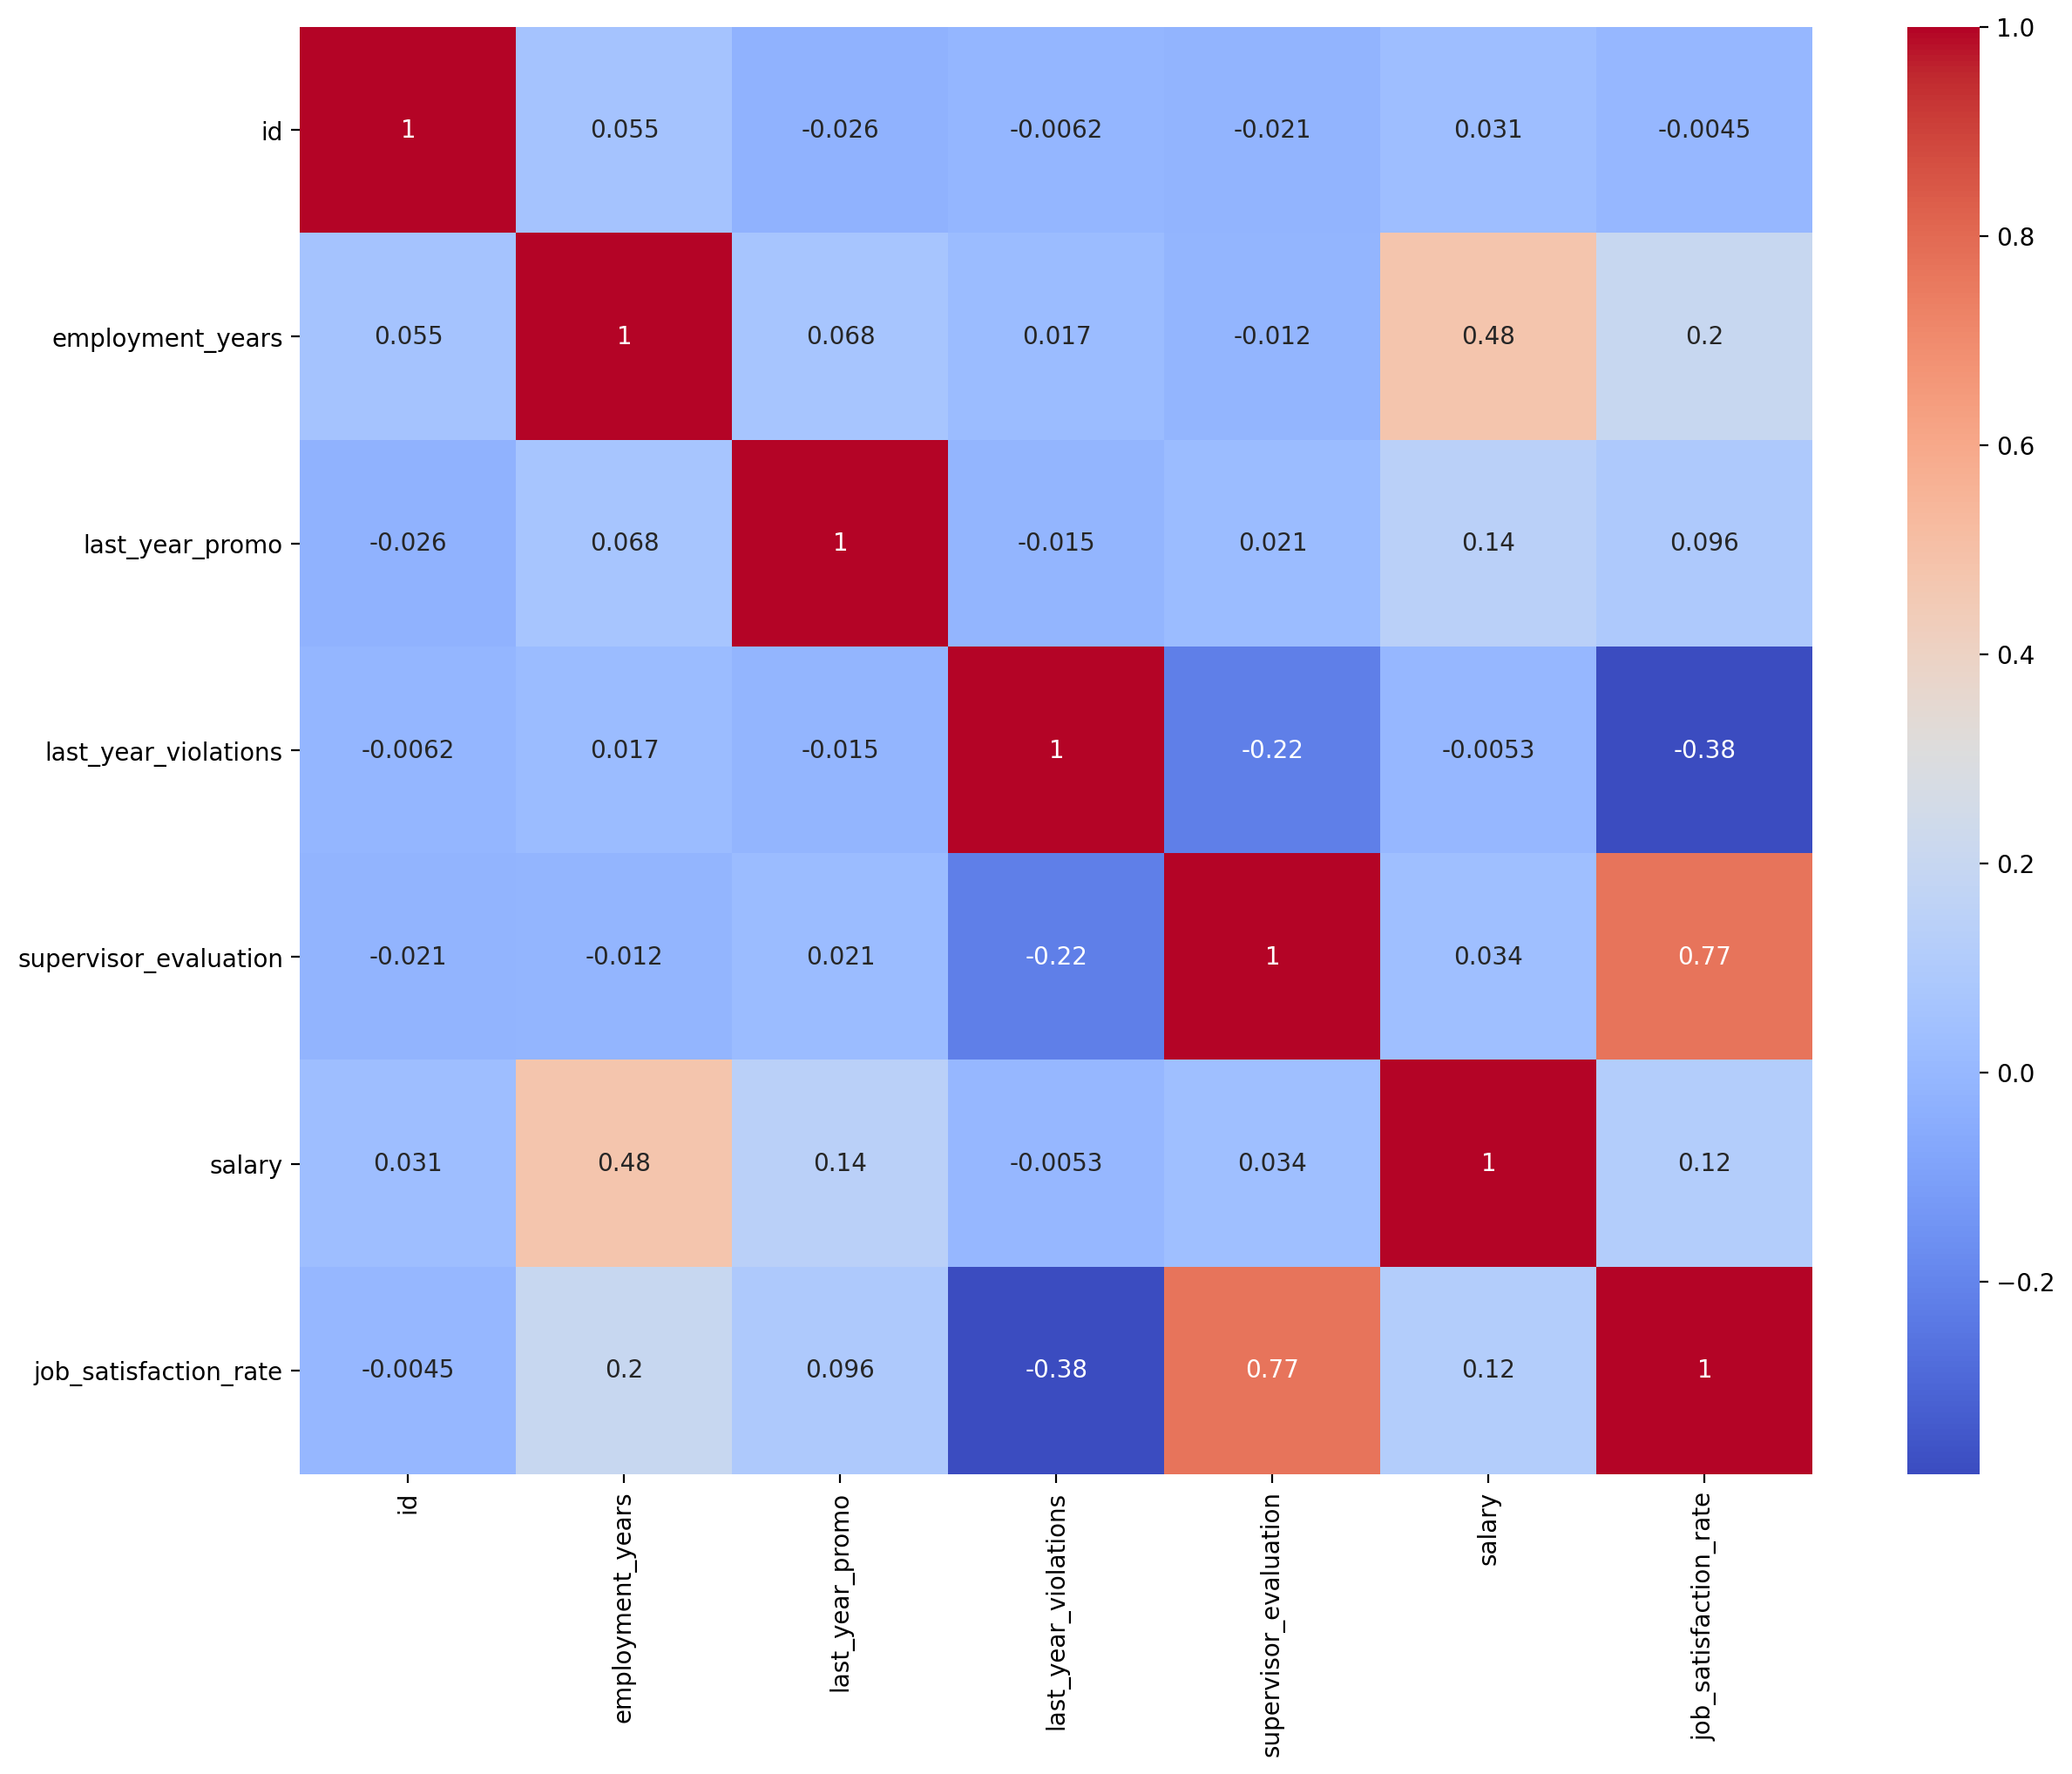

In [101]:
corr_quit = train_quit.corr(method = 'spearman')

plt.figure(figsize=(14,11), dpi=200)
sns.heatmap(corr_quit, annot = True, cmap = 'coolwarm')
plt.show()

- Мультиколлинеарность отсутствует, но есть сильная зависимость между `job_satisfaction_rate` и `supervisor_evaluation`
- Также есть зависимость между зарплатой и сроком работы, логично, чем больше работаешь, тем выше квалификация и соответственно з/п

- Такие же зависимости, как и на графике выше

# Шаг 4. Добавление нового входного признака

Допустим, `job_satisfaction_rate` и `quit` действительно связаны и вы получили необходимое значение метрики в первой задаче. 

- Тогда добавьте `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

Уже добавили в пункте выше

In [102]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,0,0,4,54000,no,0.647778
1,814010,sales,junior,medium,2,0,0,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,0,0,1,37200,no,0.340000
3,257132,sales,junior,medium,2,0,1,3,24000,yes,0.356875
4,910140,marketing,junior,medium,2,0,0,5,25200,no,0.690000


# Шаг 5. Подготовка данных

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [103]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,0,0,4,54000,no,0.647778
1,814010,sales,junior,medium,2,0,0,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,0,0,1,37200,no,0.340000
3,257132,sales,junior,medium,2,0,1,3,24000,yes,0.356875
4,910140,marketing,junior,medium,2,0,0,5,25200,no,0.690000


In [104]:
train_quit['id'].isin(test_features['id']).sum()

0

In [105]:
train_quit_2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [106]:
test_target_quit['id'].isin(test_features['id'])

0       True
1       True
2       True
3       True
4       True
        ... 
1995    True
1996    True
1997    True
1998    True
1999    True
Name: id, Length: 2000, dtype: bool

Упорядочим test_target_quit и test_features по id до полного пересечения

In [107]:
test_target_quit = test_target_quit.sort_values('id')
test_target_quit.head()

,id,quit,job_satisfaction_rate
0,100298,no,0.832222
1,100480,no,0.841667
2,100503,no,0.769333
3,100610,no,0.815000
4,100692,no,0.702500


In [108]:
test_features = test_features.sort_values('id')
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,0,0,4,19200,0.832222
1,100480,marketing,junior,low,4,0,0,4,16800,0.841667
2,100503,purchasing,middle,high,5,0,0,4,55200,0.769333
3,100610,sales,middle,medium,5,0,0,4,43200,0.815000
4,100692,sales,middle,high,6,0,0,4,48000,0.702500


In [109]:
#test_features = test_features.drop(['index'], axis = 1)
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,0,0,4,19200,0.832222
1,100480,marketing,junior,low,4,0,0,4,16800,0.841667
2,100503,purchasing,middle,high,5,0,0,4,55200,0.769333
3,100610,sales,middle,medium,5,0,0,4,43200,0.815000
4,100692,sales,middle,high,6,0,0,4,48000,0.702500


In [110]:
test_quit_merge = test_features.merge(test_target_quit, how = 'inner', on ='id')
test_quit_merge.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_x,quit,job_satisfaction_rate_y
0,100298,hr,junior,low,2,0,0,4,19200,0.832222,no,0.832222
1,100480,marketing,junior,low,4,0,0,4,16800,0.841667,no,0.841667
2,100503,purchasing,middle,high,5,0,0,4,55200,0.769333,no,0.769333
3,100610,sales,middle,medium,5,0,0,4,43200,0.815000,no,0.815000
4,100692,sales,middle,high,6,0,0,4,48000,0.702500,no,0.702500


Сбросим `id` в тест

In [111]:
test_quit_merge = test_quit_merge.drop(['id'], axis=1).reset_index(drop=True)
test_quit_merge.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_x,quit,job_satisfaction_rate_y
0,hr,junior,low,2,0,0,4,19200,0.832222,no,0.832222
1,marketing,junior,low,4,0,0,4,16800,0.841667,no,0.841667
2,purchasing,middle,high,5,0,0,4,55200,0.769333,no,0.769333
3,sales,middle,medium,5,0,0,4,43200,0.815000,no,0.815000
4,sales,middle,high,6,0,0,4,48000,0.702500,no,0.702500


проверим дубликаты после удаления `id`

In [112]:
test_quit_merge.duplicated().sum()

504

Дубликаты в тестовой выборке присутствуют, но тут мы их оставим, т.к. тестовая выборка - имитация настоящих 

In [113]:
#train_quit['quit'] = train_quit['quit'].replace({'yes': 1, 'no': 0})
#test_quit_merge['quit'] = test_quit_merge['quit'].replace({'yes': 1, 'no': 0})

train_quit = train_quit.drop(['id'], axis=1).reset_index(drop=True)
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,sales,middle,high,2,0,0,4,54000,no,0.647778
1,sales,junior,medium,2,0,0,4,27600,no,0.853529
2,purchasing,middle,medium,5,0,0,1,37200,no,0.340000
3,sales,junior,medium,2,0,1,3,24000,yes,0.356875
4,marketing,junior,medium,2,0,0,5,25200,no,0.690000


In [114]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,sales,middle,high,2,0,0,4,54000,no,0.647778
1,sales,junior,medium,2,0,0,4,27600,no,0.853529
2,purchasing,middle,medium,5,0,0,1,37200,no,0.340000
3,sales,junior,medium,2,0,1,3,24000,yes,0.356875
4,marketing,junior,medium,2,0,0,5,25200,no,0.690000


In [115]:
test_quit_merge.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_x,quit,job_satisfaction_rate_y
0,hr,junior,low,2,0,0,4,19200,0.832222,no,0.832222
1,marketing,junior,low,4,0,0,4,16800,0.841667,no,0.841667
2,purchasing,middle,high,5,0,0,4,55200,0.769333,no,0.769333
3,sales,middle,medium,5,0,0,4,43200,0.815000,no,0.815000
4,sales,middle,high,6,0,0,4,48000,0.702500,no,0.702500


In [116]:
test_quit_merge['job_satisfaction_rate'] = test_quit_merge['job_satisfaction_rate_x']
test_quit_merge = test_quit_merge.drop(['job_satisfaction_rate_y','job_satisfaction_rate_x'],axis = 1)
test_quit_merge.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,hr,junior,low,2,0,0,4,19200,no,0.832222
1,marketing,junior,low,4,0,0,4,16800,no,0.841667
2,purchasing,middle,high,5,0,0,4,55200,no,0.769333
3,sales,middle,medium,5,0,0,4,43200,no,0.815000
4,sales,middle,high,6,0,0,4,48000,no,0.702500


In [117]:
# загружаем данные
X_train_2 = train_quit.drop(['quit'], axis=1)
y_train_2 = train_quit['quit']
X_test_2 = test_quit_merge.drop(['quit'], axis=1)
y_test_2 = test_quit_merge['quit']
 

In [118]:
y_test_2

0        no
1        no
2        no
3        no
4        no
       ... 
1995     no
1996    yes
1997    yes
1998     no
1999    yes
Name: quit, Length: 2000, dtype: object

In [119]:
le = LabelEncoder()
le.fit(y_train_2)
y_train_2 = le.transform(y_train_2)
y_test_2 = le.transform(y_test_2)

In [120]:
y_test_2

array([0, 0, 0, ..., 1, 0, 1])

In [121]:

# создаём списки с названиями признаков
ohe_columns_2 = ['dept', 'level', 'workload']
ord_columns_2 = ['last_year_promo', 'last_year_violations']
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
 
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe_2 = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])
 
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['0', '1'], 
                            ['0', '1']], 
         handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])
 
# создаём общий пайплайн для подготовки данных
data_preprocessor_2 = ColumnTransformer(
    [('ohe', ohe_pipe_2, ohe_columns_2),
     ('ord', ord_pipe_2, ord_columns_2),
     ('num', StandardScaler(), num_columns_2)
    ], 
    remainder='passthrough')
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])
 
param_grid_2 = [
    {'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(2,15),
     'models__max_features': range(2,15),
     'models__min_samples_split': range(2, 10),
     'models__min_samples_leaf': range(1, 10)},
 
    {'models': [LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear',
        penalty='l1')],
     'models__C': range(1,10)},
 
    {'models': [SVC(random_state=RANDOM_STATE, probability=True)],
     'models__C':[0.1,1,10],
     'models__kernel':['linear'],
     'models__degree':[1,3,4],
     'models__gamma':[1, 0.1, 0.01]}]
 
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise')
randomized_search_2.fit(X_train_2, y_train_2)
 
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print('Метрика ROC-AUC для лучшей модели на тренировочных данных:', randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'level',
                                                   'workload']),
                                                 ('ord',
                                                  

DecisionTreeClassifier(max_depth=7, max_features=11,
                                        min_samples_leaf=8, min_samples_split=8,
                                        random_state=42))])
Метрика ROC-AUC для лучшей модели на тренировочных данных:  93 %

In [122]:
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,hr,junior,low,2,0,0,4,19200,0.832222
1,marketing,junior,low,4,0,0,4,16800,0.841667
2,purchasing,middle,high,5,0,0,4,55200,0.769333
3,sales,middle,medium,5,0,0,4,43200,0.815000
4,sales,middle,high,6,0,0,4,48000,0.702500


**Проверка модели на тестовой выборке**

In [123]:
y_pred_2 = randomized_search_2.predict(X_test_2)

roc_auc_score(y_test_2, y_pred_2)

0.8853320887413817

Отлично, на тестовой выборке метрика не сильно "просела", всего на 5 процентов - это хороший результат

# Выводы

В ходе выполнения данного проекта передо мной стояли следующие задачи:
- Предсказание удовлетворенности работников компании
- Предсказание увольнения сотрудников из компании

На работу были предоставлены следующие датасеты:

**Задача 1**

Тренировочная выборка:
- `train_job_satisfaction_rate.csv`


Входные признаки тестовой выборки:
- `test_features.csv`


Целевой признак тестовой выборки:
- `test_target_job_satisfaction_rate.csv`


**Задача 2**

Тренировочная выборка:
- `train_quit.csv`


Входные признаки тестовой выборки те же, что и в прошлой задаче:
- `test_features.csv`


Целевой признак тестовой выборки:
- `test_target_quit.csv`


**Работа была поделена на много этапов:**

- Загрузка датасетов и изучение данных, мы выяснили, соответствуют ли они описанию поставленной задачи и стандартам оформления данных. По итогу, были переименованы столбцы.


- Предобработка данных. Во время предобработки данных датасеты были изучены на наличие пропусков, дубликатов, также была проверена корректность типов данных и устранены некоторые ошибки в данных, которые в дальнейшем могли привести к серьезным ошибкам при тренировке моделей.


- Исследовательский анализ данных. Был проведен анализ, в ходе которого были построены графики для каждого признака, с учетом того, к какому классу они принадлежат (количественные или категориальный типы). В некоторых признаках были замечены выбросы, которые успешно устранили.


- Корреляционный анализ признаков. Были изучены взаимосвязи между признаками, рассчитаны коэффициенты корреляции между всеми признаками. Были получены выводу о типах взаимосвязи между целевым и входными признаками, наличие нелинейных связей в признаках, наличие мультиколлинеарности.


- Cоздание пайплайна для обучения модели (было очень много разных моделей) на разных метриках, чтобы в итоге получить лучшую.

**Задача 1**

Для предсказания удовлетворенности пользователей использовалась метрика `SMAPE`.
Критерий успеха: `SMAPE` ≤ 15 на тестовой выборке.

Лучшая полученная модель:
- DecisionTreeRegressor(max_depth=16, max_features=16, min_samples_split=20), она справилась лучше, так как когда были построены графики, то сразу стало понятно, что обычная линейная регрессия не справится с такой задачей, потому что в данных не было сильной линейной зависимости

- Значение на тестовой выборке - 13.7 (что подходит под ограничение)


**Задача 2**

Для предсказания ухода человека из компании использовалась метрика `ROC-AUC`

Лучшая полученная модель:
- DecisionTreeClassifier(max_depth=7, max_features=11,min_samples_leaf=8, min_samples_split=8)
  Метрика ROC-AUC для лучшей модели на тренировочных данных:  93 %

- Значение на тестовой выборке - 88 %, что в принципе неплохо


**Советы бизнесу:**

После проведенного анализа можно дать следующие советы по улучшению бизнеса:

- Была замечена зависимость между ухдом из компании и повышениями за последний год, а также зарплатой. Поэтому есть предложение повысить зарплату хорошим сотрудникам, чтобы их удовлетворенность была выше.

- Понизить уровень загруженности сотрудников

- Проводить собрания (общие), на которых выявлять, что не нравится на данный момент в работе компании и получать советы, как это можно устранить.

Мы смогли построить модели, которые предсказыют удовлетворенность работников, а также модель показывает тех, кто уволится. Это очень поможет в бизнесе и компании в целом